U_NET neural network structure definition:
Dataset link: https://www.ucl.ac.uk/interventional-surgical-sciences/weiss-open-research/weiss-open-data-server/ex-vivo-dvrk-segmentation-dataset-kinematic-data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Every inputh path in the script
#'''
#Bence
dataset_images_path = "/content/data/Dataset/"
x_train_path = '/content/Test/train data/X_train.npy'
y_train_path = '/content/Test/train data/Y_train.npy'
model_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Models/unet_10_epoch.h5'
test_image_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset/'
output_image_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/output_image.png'
output_segmented_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/segmented_image.png'
#'''

'''
dataset_images_path = "/content/data/Dataset/" 
x_train_path = '/content/Test/train data/X_train.npy'
y_train_path = '/content/Test/train data/Y_train.npy'
model_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Models/unet_10_epoch.h5'
test_image_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset/'
output_image_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/output_image.png'
output_segmented_path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/segmented_image.png'
'''

'\n#Lajos\ndataset_images_path = "/content/data/Dataset/" \nx_train_path = \'/content/Test/train data/X_train.npy\'\ny_train_path = \'/content/Test/train data/Y_train.npy\'\nmodel_path = \'/content/drive/MyDrive/Szerviz_Robotok_Beadando/Models/unet_10_epoch.h5\'\ntest_image_path = \'/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset/\'\noutput_image_path = \'/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/output_image.png\'\noutput_segmented_path = \'/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/segmented_image.png\'\n'

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the U-Net architecture
def unet(input_size=(256, 256, 1)):
    inputs = tf.keras.layers.Input(input_size)
    
    # Contracting path
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)
    
    # Expanding path
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = tf.keras.layers.concatenate([drop4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

Copy Drive saved dataset to colab

In [16]:
#!cp source_filepath destination_filepath
#Lajos
#!cp "/content/drive/MyDrive/Dataset/Dataset.zip" "/content/data/"
#Bence
!cp "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset.zip" "/content/data/"

In [17]:
!unzip "/content/data/Dataset.zip" -d "/content/data"

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: /content/data/Dataset/Video_014/images/124.png  
  inflating: /content/data/Dataset/Video_014/images/125.png  
  inflating: /content/data/Dataset/Video_014/images/126.png  
  inflating: /content/data/Dataset/Video_014/images/127.png  
  inflating: /content/data/Dataset/Video_014/images/128.png  
  inflating: /content/data/Dataset/Video_014/images/129.png  
  inflating: /content/data/Dataset/Video_014/images/130.png  
  inflating: /content/data/Dataset/Video_014/images/131.png  
  inflating: /content/data/Dataset/Video_014/images/132.png  
  inflating: /content/data/Dataset/Video_014/images/133.png  
  inflating: /content/data/Dataset/Video_014/images/134.png  
  inflating: /content/data/Dataset/Video_014/images/135.png  
  inflating: /content/data/Dataset/Video_014/images/136.png  
  inflating: /content/data/Dataset/Video_014/images/137.png  
  inflating: /content/data/Dataset/Video_014/images/138.png  
  inflating: /conte

Create X_train and Y_train data

In [18]:
import numpy as np
import os
import cv2

# Load the input images and ground truth masks into NumPy arrays
X_train = []
Y_train = []

for i in range(10):
  i = i+1
  # Define the path to the input images and ground truth masks
  #input_path = "Dataset/Video_" + str(i) + "/images"
  input_path = dataset_images_path + "Video_0"  + str(i) + "/images"  #"/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset/Video_" + str(i) + "/images"
  #mask_path = "Dataset/Video_" + str(i) + "/ground_truth"
  mask_path = dataset_images_path + "Video_0" + str(i) + "/ground_truth" #"/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset/Video_" + str(i) + "/ground_truth"

  # Get a list of the input and mask files
  input_files = os.listdir(input_path)
  mask_files = os.listdir(mask_path)

  # Sort the files to ensure that the input and mask files correspond to each other
  input_files.sort()
  mask_files.sort()

  #for input_file, mask_file in zip(input_files, mask_files):

  for input_file, mask_file in zip(input_files, mask_files):
      # Load the input image as a grayscale image with a size of 256x256 pixels
      input_image = cv2.imread(os.path.join(input_path, input_file), cv2.IMREAD_GRAYSCALE)
      input_image = cv2.resize(input_image, (256, 256))

      # Load the ground truth mask as a grayscale image with a size of 256x256 pixels
      mask_image = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
      mask_image = cv2.resize(mask_image, (256, 256))

      # Normalize the input image
      #input_image = input_image / 255.0
      input_image = input_image.astype('float32') / 255.0

      # Normalize the mask image (assuming it contains only 0s and 255s)
      #mask_image = mask_image / 255.0
      mask_image = mask_image.astype('float32') / 255.0

      # Add the input and mask images to the X_train and Y_train arrays
      X_train.append(input_image)
      Y_train.append(mask_image)

# Convert the X_train and Y_train arrays to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Save the X_train and Y_train arrays as NumPy binary files
np.save(x_train_path, X_train)
np.save(y_train_path, Y_train)


In [54]:
#Copy to Drive
!cp "/content/Test/train data/X_train.npy" "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Data_formated"
!cp "/content/Test/train data/Y_train.npy" "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Data_formated"

In [4]:
#Copy from Drive
!cp "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Data_formated/X_train.npy" "/content/Test/train data/"
!cp "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Data_formated/Y_train.npy" "/content/Test/train data/"

3000
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


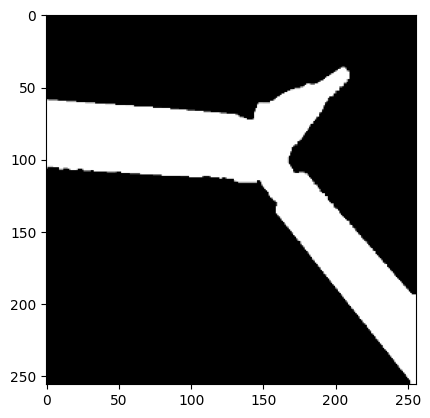

In [19]:
from PIL import Image
import numpy as np
data = np.load(y_train_path)

data.shape
print(len(data))
plt.imshow(data[499], cmap='gray')
  
print(data)
plt.show()

Load created .npy files:

In [23]:
X_train = np.load(x_train_path)
Y_train = np.load(y_train_path)
#X_train = np.load('/content/drive/MyDrive/Szerviz_robotok/Data_formated/X_train.npy')
#Y_train = np.load('/content/drive/MyDrive/Szerviz_robotok/Data_formated/Y_train.npy')
#X_train = X_train.astype('float32') / 255.
#Y_train = Y_train.astype('float32') / 255.


3000


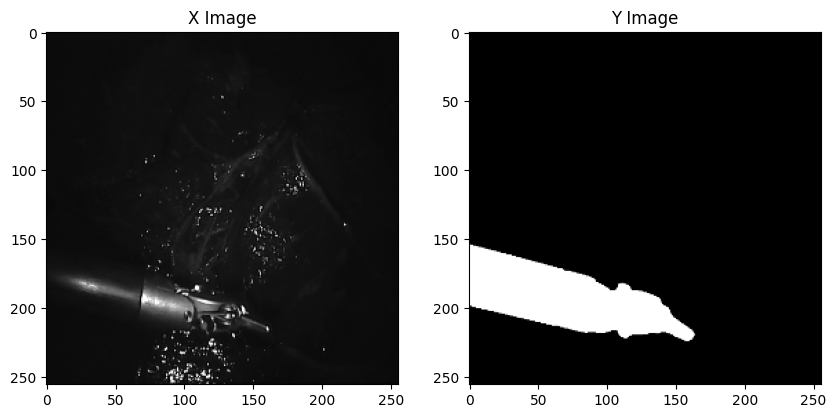

In [21]:
#print(X_train)
print(len(X_train))
index = 2000

X_train.shape
#print(len(X_train))
#plt.imshow(Y_train[4100], cmap='gray')

# Display the input image and the segmented image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
input_image = axs[0].imshow(X_train[index], cmap='gray')
axs[0].set_title('X Image')
segmented = axs[1].imshow(Y_train[index], cmap='gray')
axs[1].set_title('Y Image')
plt.show()

In [24]:
print(X_train)
print(len(Y_train))

[[[0.13333334 0.14117648 0.13725491 ... 0.17254902 0.1764706  0.1882353 ]
  [0.13333334 0.14117648 0.13725491 ... 0.18039216 0.1764706  0.1764706 ]
  [0.13725491 0.14117648 0.14509805 ... 0.17254902 0.17254902 0.1764706 ]
  ...
  [0.15294118 0.15686275 0.16078432 ... 0.10588235 0.10980392 0.10980392]
  [0.15686275 0.15686275 0.16470589 ... 0.10588235 0.10980392 0.10980392]
  [0.16078432 0.16862746 0.17254902 ... 0.09803922 0.09803922 0.09803922]]

 [[0.12941177 0.13725491 0.13725491 ... 0.17254902 0.1764706  0.18431373]
  [0.13725491 0.14117648 0.13725491 ... 0.1764706  0.1764706  0.18039216]
  [0.13725491 0.14117648 0.14117648 ... 0.16862746 0.17254902 0.18039216]
  ...
  [0.14901961 0.15294118 0.16078432 ... 0.10588235 0.10980392 0.10980392]
  [0.16078432 0.15294118 0.16078432 ... 0.10588235 0.10980392 0.10980392]
  [0.17254902 0.16862746 0.1764706  ... 0.09411765 0.09803922 0.09803922]]

 [[0.13333334 0.13725491 0.13725491 ... 0.17254902 0.17254902 0.18431373]
  [0.13725491 0.137254

To carry out teaching:

In [29]:
model = unet(input_size=(256, 256, 1))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#RMSprop
#SGD
#Adam
#Adadelta
#Adagrad
#Nadam

#binary_crossentropy
#categorical_crossentropy
#sparse_categorical_crossentropy
#mean_squared_error

history = model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=32)

#model.save("/content/Test/test_model_01.h5")
#!cp "/content/Test/test_model_01.h5" "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Models"

Epoch 1/10
75/75 [==============================] - 158s 2s/step - loss: 0.3949 - accuracy: 0.8790 - val_loss: 0.3387 - val_accuracy: 0.8690
Epoch 2/10
75/75 [==============================] - 137s 2s/step - loss: 0.2081 - accuracy: 0.8790 - val_loss: 0.1893 - val_accuracy: 0.8690
Epoch 3/10
75/75 [==============================] - 139s 2s/step - loss: 0.1071 - accuracy: 0.9688 - val_loss: 0.1357 - val_accuracy: 0.9700
Epoch 4/10
75/75 [==============================] - 136s 2s/step - loss: 0.0900 - accuracy: 0.9873 - val_loss: 0.1323 - val_accuracy: 0.9711
Epoch 5/10
75/75 [==============================] - 136s 2s/step - loss: 0.0832 - accuracy: 0.9900 - val_loss: 0.1280 - val_accuracy: 0.9755
Epoch 6/10
75/75 [==============================] - 138s 2s/step - loss: 0.0785 - accuracy: 0.9912 - val_loss: 0.1247 - val_accuracy: 0.9772
Epoch 7/10
75/75 [==============================] - 137s 2s/step - loss: 0.0744 - accuracy: 0.9918 - val_loss: 0.1305 - val_accuracy: 0.9757
Epoch 8/10
75

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_train, Y_train)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

132/132 [==============================] - 62s 469ms/step - loss: 0.2260 - accuracy: 0.8805
Test loss: 0.2259591817855835
Test accuracy: 0.8805307149887085


Show results:

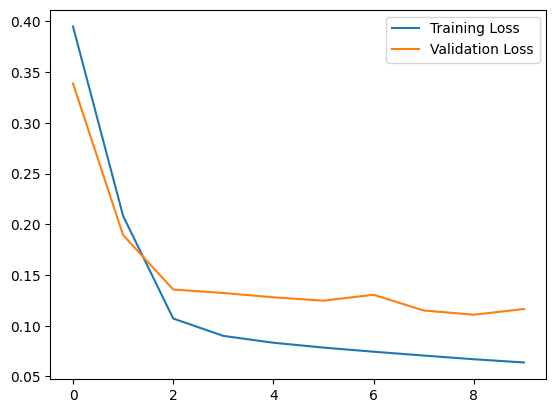

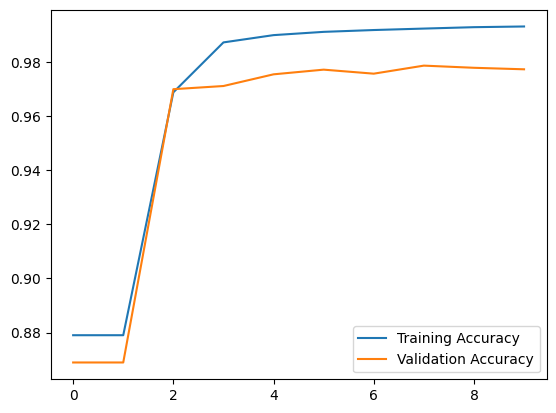

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

Save the developed model:

In [48]:
!cp "/content/Test/test_model_01.h5" "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Models"

In [10]:
!cp "/content/drive/MyDrive/Szerviz_Robotok_Beadando/Models/test_model_01.h5" "/content/Test/"

In [31]:
#model.save(model_path)
model.save("/content/Test/test_model_01.h5")

Testing:

000
/content/data/Dataset/Video_01/images/000.png
1/1 [==============================] - 0s 254ms/step
[[6.38450147e-04 1.69518529e-07 2.43868215e-09 ... 2.18608402e-08
  1.57278846e-05 6.17138389e-03]
 [3.29735994e-09 1.20817538e-12 5.71637100e-18 ... 1.44766676e-15
  1.29806148e-11 3.11575127e-06]
 [6.53137475e-11 5.18879728e-18 2.58641853e-25 ... 1.69316046e-21
  3.95106353e-16 5.98749139e-08]
 ...
 [3.85496560e-06 1.42110390e-09 5.77903773e-13 ... 6.19658291e-01
  6.19658291e-01 6.19658291e-01]
 [1.07059539e-04 1.20338782e-07 7.46093243e-10 ... 6.19658291e-01
  6.19658291e-01 6.19658291e-01]
 [1.13005172e-02 1.19164186e-04 5.74729074e-06 ... 6.19658291e-01
  6.19658291e-01 6.19658291e-01]]
001
/content/data/Dataset/Video_01/images/001.png
1/1 [==============================] - 0s 23ms/step
[[6.5994984e-04 1.8320375e-07 2.6517275e-09 ... 2.1405043e-08
  1.5544801e-05 6.1430074e-03]
 [3.5781988e-09 1.3722342e-12 6.8087172e-18 ... 1.3963934e-15
  1.2719693e-11 3.0805240e-06]
 [7.19702

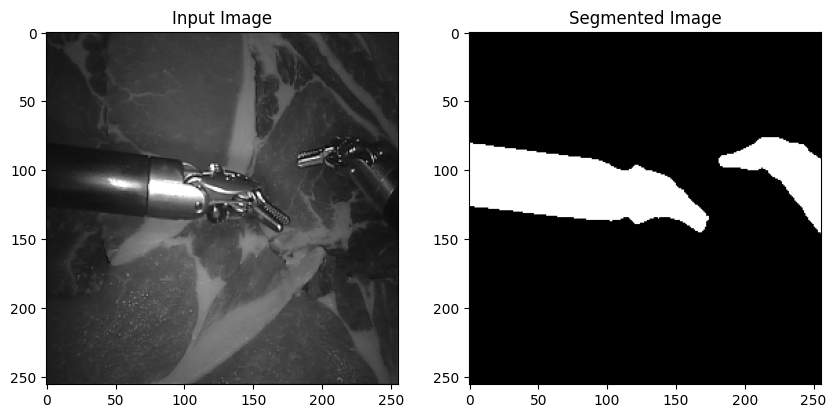

In [49]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the trained U-Net model from disk

#model = tf.keras.models.load_model(model_path)
model = tf.keras.models.load_model("/content/Test/test_model_01.h5")

for i in range(300):
  i = f"{i:03d}"
  print(i)
  #path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Dataset/Dataset/Video_02/images/' + str(i) + '.png'
  path = '/content/data/Dataset/Video_01/images/' + str(i) + '.png'
  print(path)

  # Load the input image for segmentation
  input_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  input_image = cv2.resize(input_image, (256, 256))

  #Save img for testing
  input_image_color = cv2.imread(path, cv2.IMREAD_COLOR)
  input_image_color = cv2.resize(input_image_color, (256, 256))
  #cv2.imwrite(output_image_path, input_image_color)
  # convert bgr to rgb 
  #rgb = cv2.cvtColor(input_image_color, cv2.COLOR_BGR2RGB)
  #plt.imshow(rgb, cmap = plt.cm.Spectral)

  # Preprocess the input image for the U-Net model
  input_image = input_image.astype('float32') / 255.0
  input_image = np.expand_dims(input_image, axis=-1)
  input_image = np.expand_dims(input_image, axis=0)

  # Use the U-Net model to perform segmentation on the input image
  output_mask = model.predict(input_image)
  
  # Postprocess the output mask to obtain the segmented image
  output_mask = output_mask.squeeze()
  print(output_mask)
  output_mask = (output_mask > 0.5).astype('uint8') * 255

  # Convert the output mask to a 3-channel RGB image
  output_mask = cv2.cvtColor(output_mask, cv2.COLOR_GRAY2RGB)

  #cv2.imwrite('/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/Video_01/'+ str(i) + 'segmented.png', output_mask)
  cv2.imwrite('/content/Test/Segmented pictures/'+ str(i) + 'segmented.png', output_mask)

# Display the input image and the segmented image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
input_image = axs[0].imshow(input_image.squeeze(), cmap='gray')
axs[0].set_title('Input Image')
segmented = axs[1].imshow(output_mask)

axs[1].set_title('Segmented Image')
plt.show()


000
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


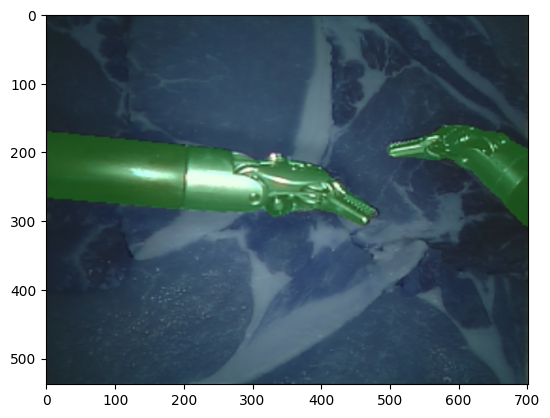

In [50]:
for i in range(300):
  i = f"{i:03d}"
  print(i)

  #path = '/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/Video_01/' + str(i) + 'segmented.png'
  path = '/content/Test/Segmented pictures/' + str(i) + 'segmented.png'
  
  # Load the binary image
  binary_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  
  # Load the color image
  
  color_img = cv2.imread("/content/data/Dataset/Video_01/images/" + str(i) + '.png', cv2.IMREAD_COLOR)
  #color_img = cv2.imread(output_image_path, cv2.IMREAD_COLOR)
  color_img = cv2.resize(color_img, (256, 256))
  plt.imshow(color_img)
  # Create a mask for the white pixels in the binary image
  white_mask = cv2.threshold(binary_img, 127, 255, cv2.THRESH_BINARY)[1]

  # Apply the mask to the color image
  masked_color_img = cv2.bitwise_and(color_img, color_img, mask=white_mask)

  # Invert the mask to keep non-white pixels
  not_white_mask = cv2.bitwise_not(white_mask)

  # Apply the inverted mask to the original color image
  not_white_img = cv2.bitwise_and(color_img, color_img, mask=not_white_mask)

  # Create a new image with only the white pixels from the mask
  white_img = np.zeros_like(color_img)
  white_img[white_mask == 255] = [0, 255, 0]

  # Overlay the white image on the masked color image
  alpha = 0.2
  output_img = cv2.addWeighted(masked_color_img, 1, white_img, alpha, 0)

  # Add the not-white image to the output image
  output_img = cv2.add(output_img, not_white_img)
  output_img = cv2.resize(output_img, (701, 538))
  cv2.imwrite('/content/Test/Combined/'+ str(i) + 'combined.png', output_img)
  #cv2.imwrite('/content/drive/MyDrive/Szerviz_Robotok_Beadando/Testing/Video_01_combined/'+ str(i) + 'combined.png', output_img)

# Display the output image
plt.imshow(output_img)


Create a video from the segmented images

In [53]:
import cv2
import os

# Set the path to the directory containing the images
#image_dir = 'Synthetic_MICCAI2020_dataset\Video_01\images'
image_dir = '/content/Test/Combined'

# Set the output video file name and codec
output_file = 'output.avi'
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fps = 10  # frames per second

# Get a list of all image files in the directory
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

# Get the dimensions of the first image
image = cv2.imread(images[0])
height, width, channels = image.shape

# Create the video writer object
video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

# Loop through all the images and add them to the video
for image_file in images:
    image = cv2.imread(image_file)
    video.write(image)

# Release the video writer object and close the video file
video.release()
cv2.destroyAllWindows()
